In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Load heatmap JSON data
def load_heatmap_data(file_paths, img_size=(800,800),num_boxes = 6):
    images = []
    labels = []
    label_set = set()  # Collect all unique labels dynamically

    for file_path in file_paths:
        with open(file_path, 'r') as f:
            data = json.load(f)
            
            # Check if 'shapes' exists and is not None
            if 'shapes' not in data or data['shapes'] is None:
                print(f"Warning: 'shapes' key missing or None in {file_path}")
                continue
                
            shapes = data['shapes']

            # Create a blank heatmap
            heatmap = np.zeros(img_size)

            # Collect labels for this image
            image_labels = []

            for shape in shapes:
                if 'label' not in shape:
                    print(f"Warning: 'label' missing in {file_path}")
                    continue

                label = shape['label']
                points = shape['points']

                # Extract bounding box coordinates
                x1, y1 = points[0]
                x2, y2 = points[1]

                # Scale down coordinates to match img-size
                scale_x = img_size[0] / 1280  
                scale_y = img_size[1] / 1024  

                x1, x2 = int(x1 * scale_x), int(x2 * scale_x)
                y1, y2 = int(y1 * scale_y), int(y2 * scale_y)

                image_labels.append([x1, y1, x2, y2])
                label_set.add(label)
            # Standardize the number of bounding boxes to 'num_boxes'
            if len(image_labels) < num_boxes:
                # Pad with dummy bounding boxes
                for _ in range(num_boxes - len(image_labels)):
                    image_labels.append([0, 0, 0, 0])
            elif len(image_labels) > num_boxes:
                # Truncate extra boxes
                image_labels = image_labels[:num_boxes]
                
            images.append(heatmap)
            labels.append(image_labels)

    label_classes = sorted(label_set)
    labels = np.array(labels)

    return np.array(images), labels, label_classes

In [3]:
# File paths for JSON heatmaps
json_files = [
    "heatmap[1800,2400].json", "heatmap[3000,3600].json", "heatmap[3800,4400].json",
    "heatmap[4700,5400].json", "heatmap[5600,6300].json", "heatmap[6500,7200].json",
    "heatmap[7300,8000].json", "heatmap[8100,8800].json", "heatmap[8900,9600].json",
    "heatmap[10600,11100].json"
]

In [4]:
# ✅ Load data
images, labels_encoded, label_classes = load_heatmap_data(json_files,  img_size=(800,800))

In [5]:
# ✅ Debugging
print("Images Shape:", images.shape)
print("Encoded Labels Shape:", labels_encoded.shape)
print("Unique Labels:", label_classes)


Images Shape: (10, 800, 800)
Encoded Labels Shape: (10, 6, 4)
Unique Labels: ['Bx_ROI1', 'Bx_ROI2', 'Bz_ROI3', 'Bz_ROI4', 'Bz_ROI5', 'Bz_ROI6', 'ROI']


In [6]:
# ✅ Reshape labels correctly if needed
if labels_encoded.shape[1] == 64:
    labels_encoded = labels_encoded.reshape(-1, 6, 4)  # Ensure (num_samples, 6, 4)

In [7]:
# ✅ Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    images, labels_encoded, test_size=0.2, random_state=42
)

In [8]:
# ✅ Reshape images to include a channel dimension
X_train = X_train.reshape(-1, 800, 800, 1)
X_test = X_test.reshape(-1, 800, 800, 1)

In [9]:
# ✅ Normalize bounding boxes (scale 0-1)
y_train = y_train / 800
y_test = y_test / 800

In [10]:
# ✅ Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)
datagen.fit(X_train)

In [11]:
# ✅ CNN Model
model = Sequential([
    Input(shape=(800, 800, 1)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(6 * 4, activation='linear'),  # Output layer for bounding box regression
    Reshape((6, 4))  # Ensure output matches (6,4)
])

In [12]:
# ✅ Compile model with Mean Squared Error for bounding box regression
model.compile(
    optimizer=Adam(learning_rate=0.0005), 
    loss=MeanSquaredError(),
    metrics=['mae']
)

In [13]:
# ✅ Check dataset before training
print("y_train shape:", y_train.shape)  # Should be (num_samples, 6, 4)
print("y_test shape:", y_test.shape)

y_train shape: (8, 6, 4)
y_test shape: (2, 6, 4)


In [14]:
# ✅ Train the model
model.fit(X_train, y_train, batch_size=32, epochs=30, validation_data=(X_test, y_test))


Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - loss: 0.4016 - mae: 0.5480 - val_loss: 0.4345 - val_mae: 0.6031
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.4011 - mae: 0.5476 - val_loss: 0.4339 - val_mae: 0.6026
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.4005 - mae: 0.5472 - val_loss: 0.4333 - val_mae: 0.6021
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.4000 - mae: 0.5468 - val_loss: 0.4327 - val_mae: 0.6016
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.3995 - mae: 0.5464 - val_loss: 0.4321 - val_mae: 0.6011
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: 0.3989 - mae: 0.5460 - val_loss: 0.4315 - val_mae: 0.6006
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - loss: 0.3984 - mae: 0.5456 - val_loss: 0.4309 - val_mae: 0.6001
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.3978 - mae: 0.5452 - val_loss: 0.4303 - val_mae: 0.5996
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.3973 - mae: 0.5448 - val_lo

In [15]:
# ✅ Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {mae:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - loss: 0.4173 - mae: 0.5887
Test MAE: 0.59


In [35]:
# ✅ Visualize test image with bounding boxes
def plot_test_image_with_rois(image, labels, label_classes):
    fig, ax = plt.subplots(1, figsize=(6, 6))
    ax.imshow(image.squeeze(), cmap='gray')
    
    for i, bbox in enumerate(labels):
        x1, y1, x2, y2 = bbox * 800  # Rescale to original dimensions
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1 - 5, label_classes[i], color='r', fontsize=12, weight='bold')

    plt.title("Test Image with ROIs")
    plt.axis("off")
    plt.show()

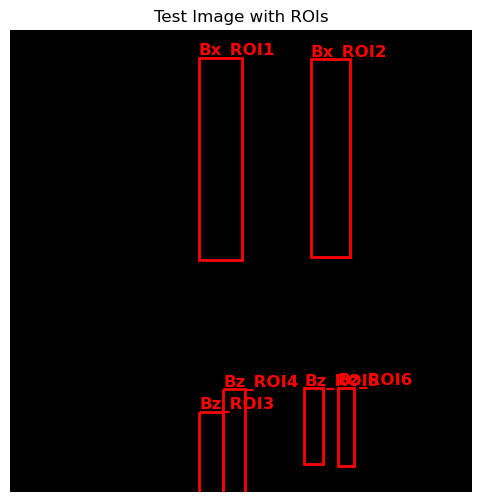

In [37]:
# ✅ Show test image with bounding boxes
sample_idx = 0
plot_test_image_with_rois(X_test[sample_idx], y_test[sample_idx], label_classes)